In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import sys
import numpy as np

sys.path.insert(0, '..')
from src.rsa import compare_rsa

/home/snail-race/projects/snail-ssl/envs/env/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


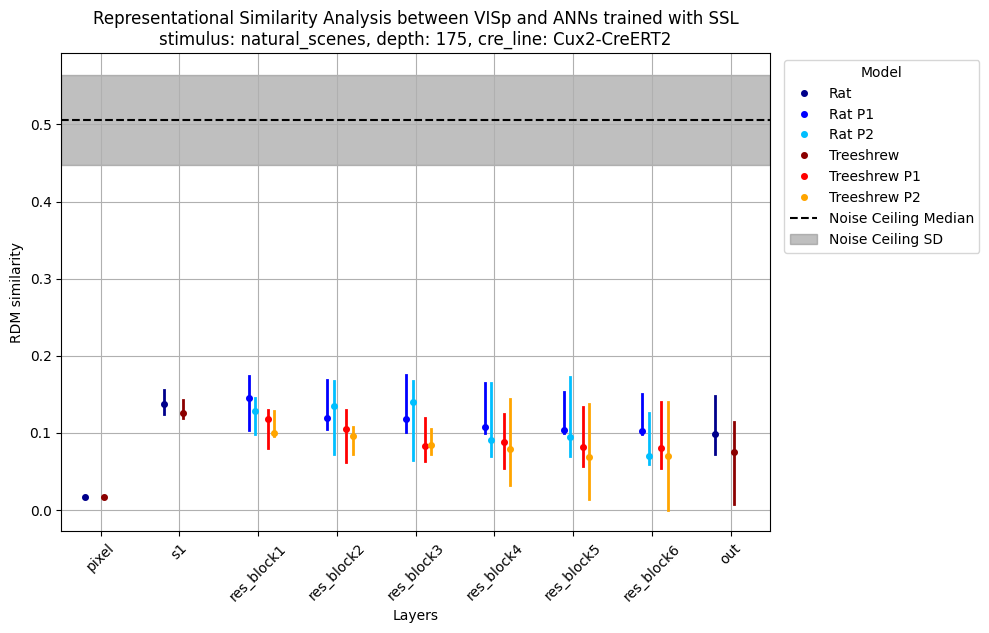

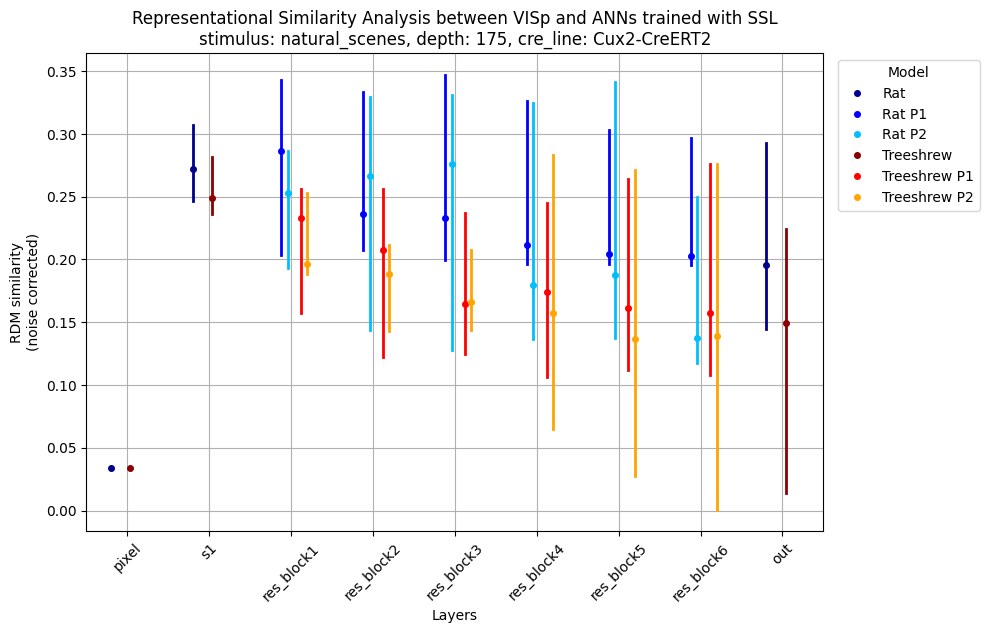

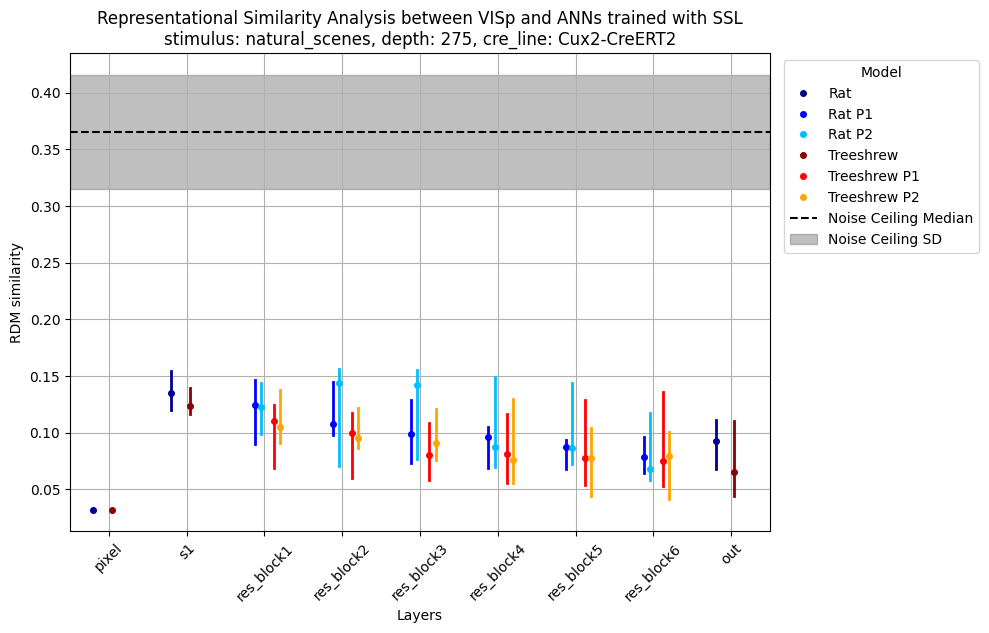

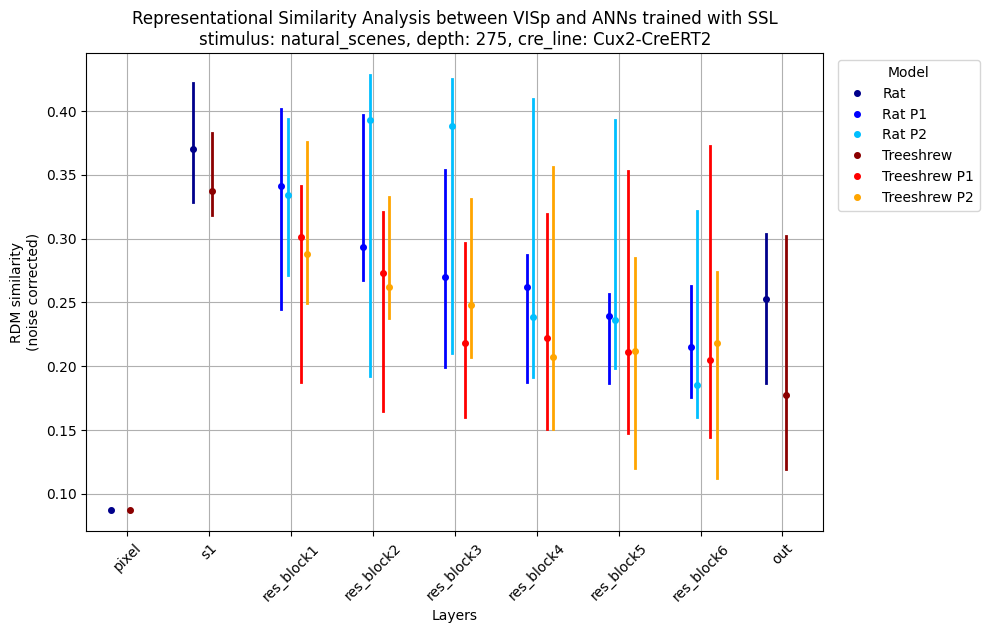

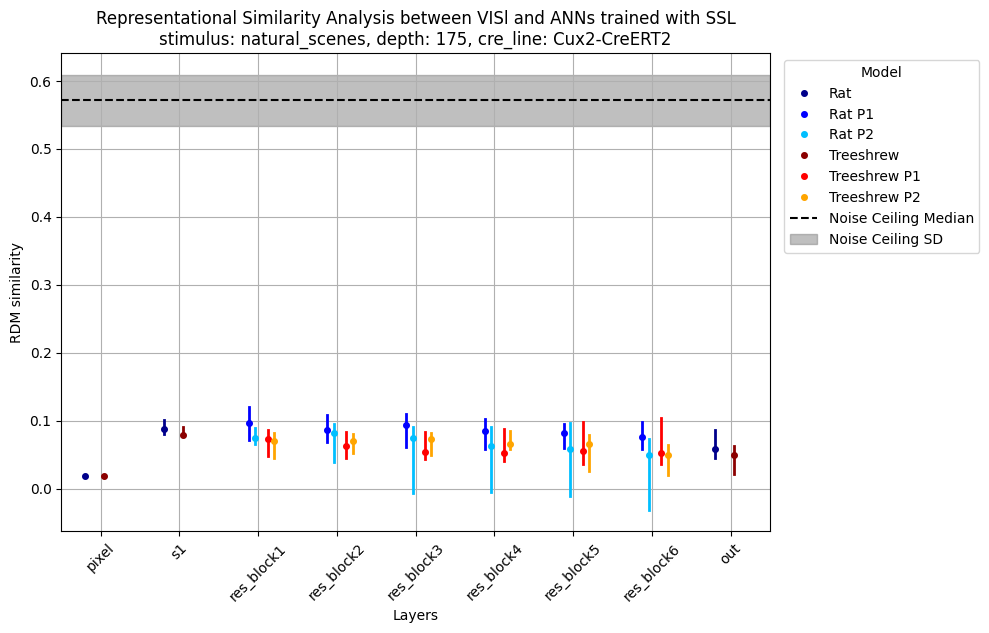

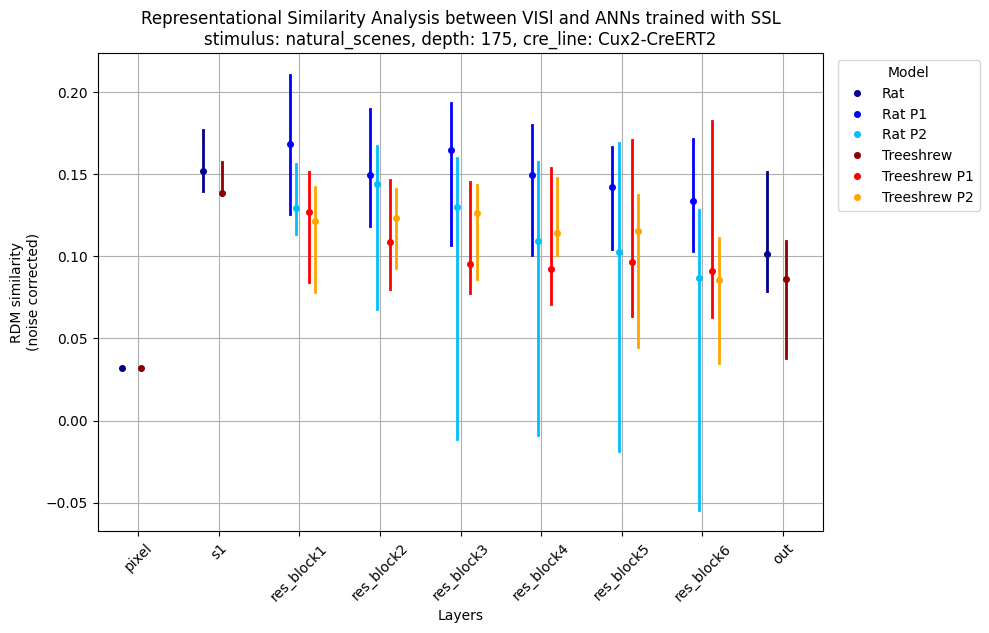

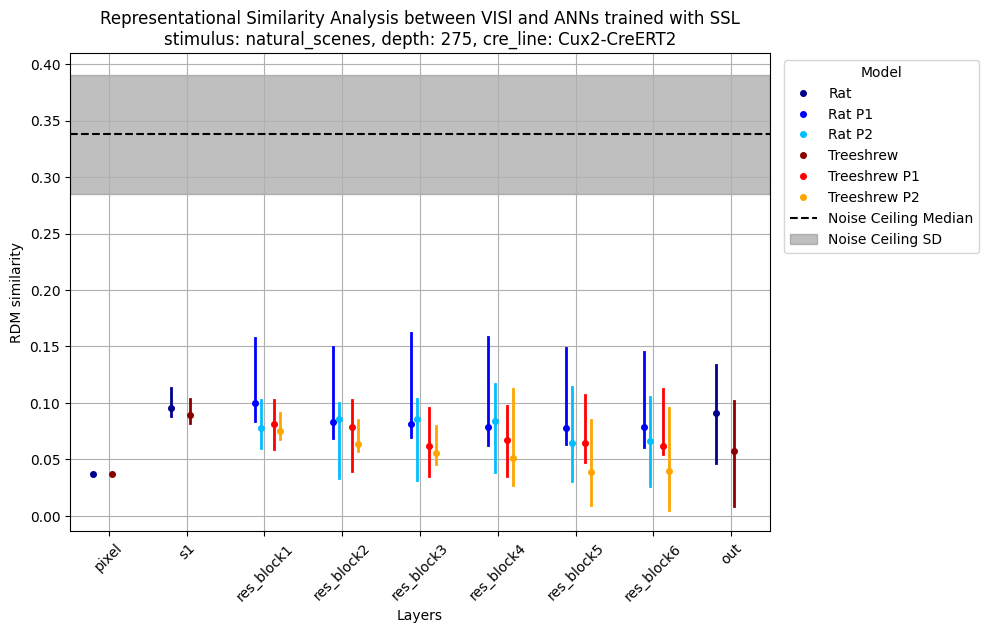

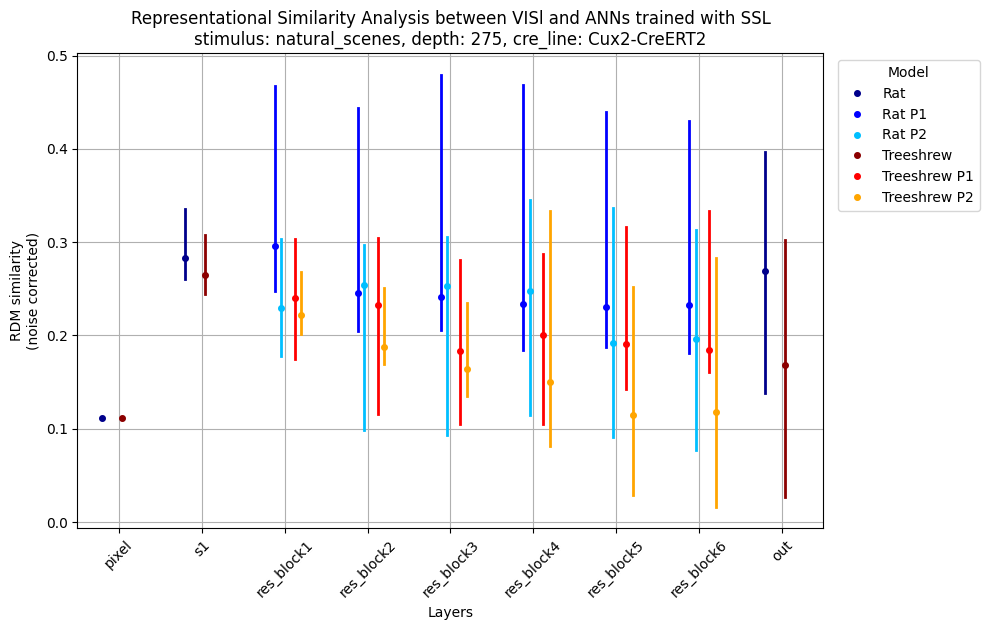

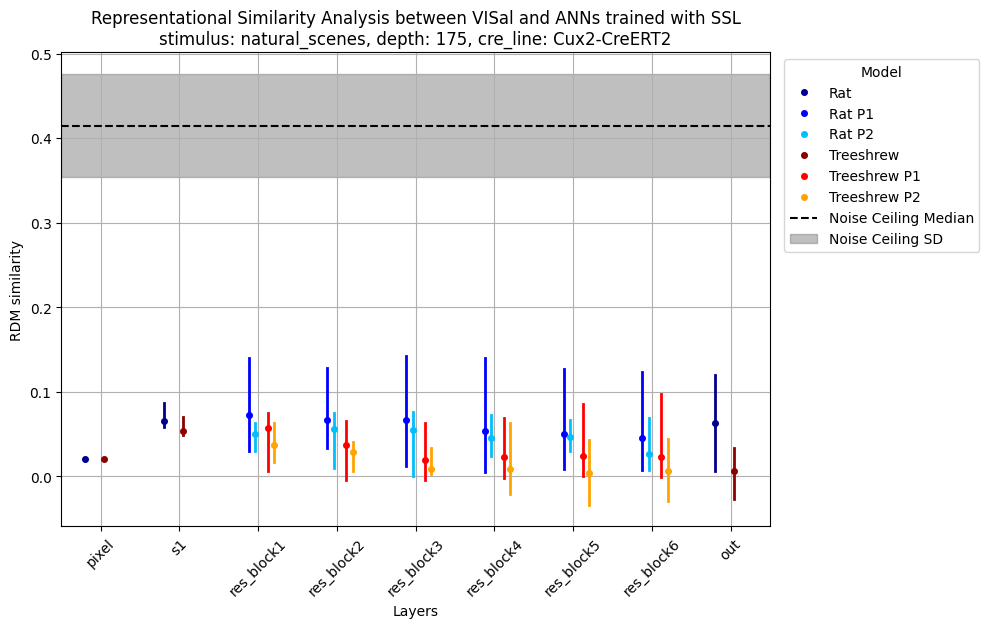

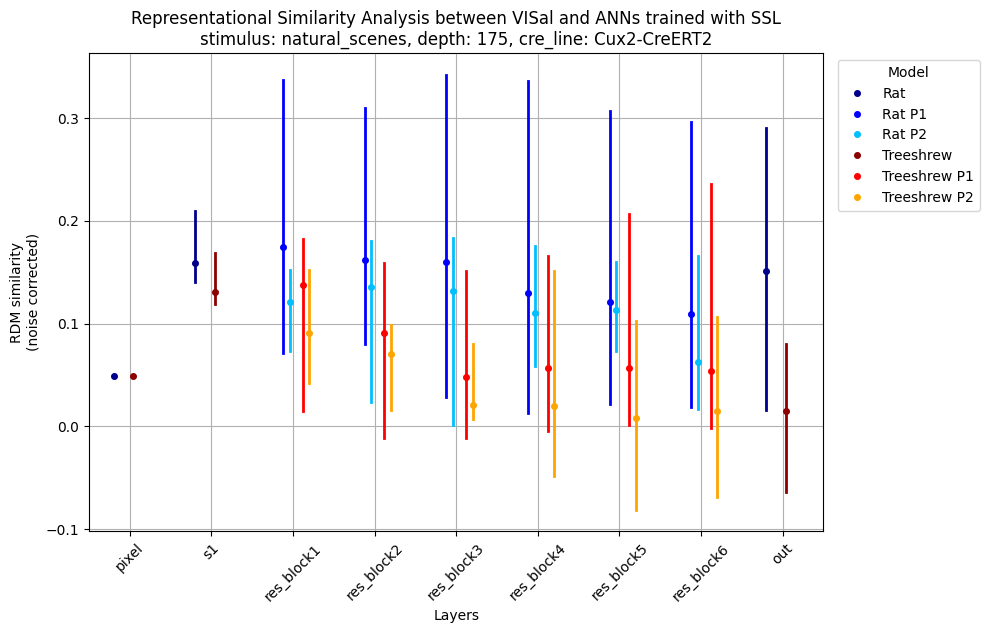

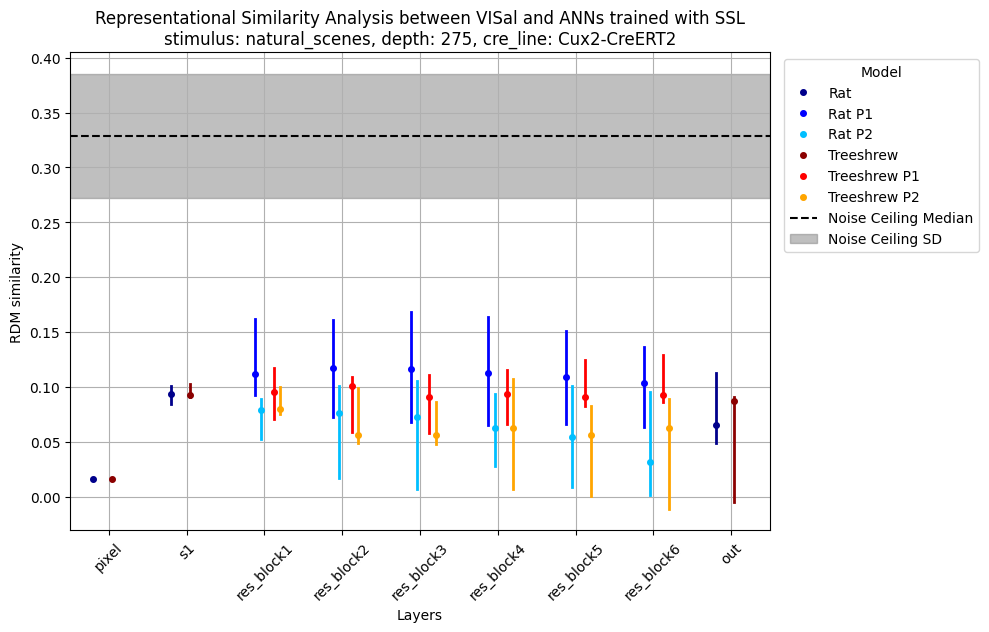

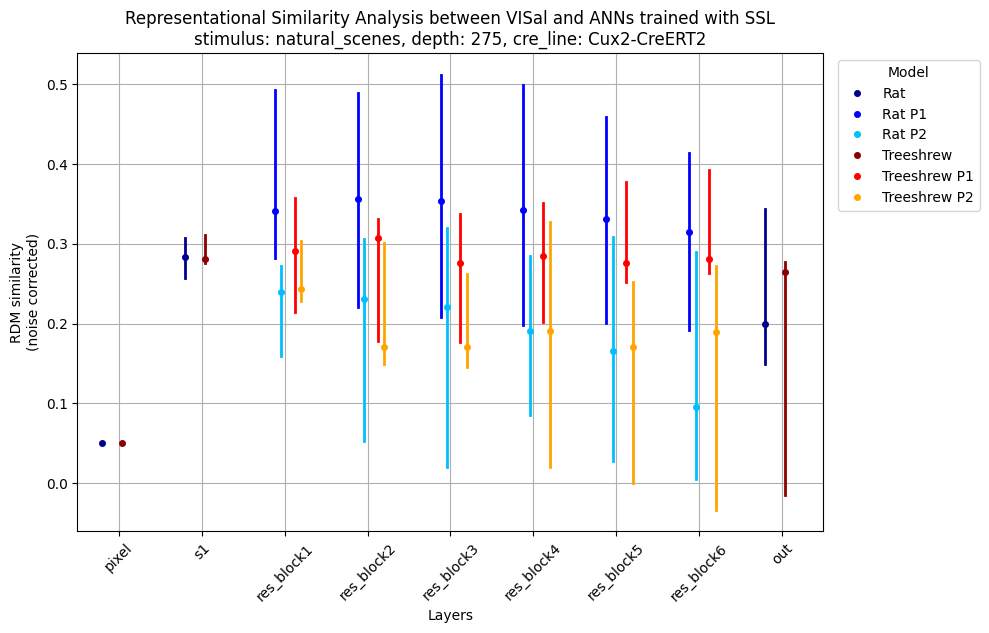

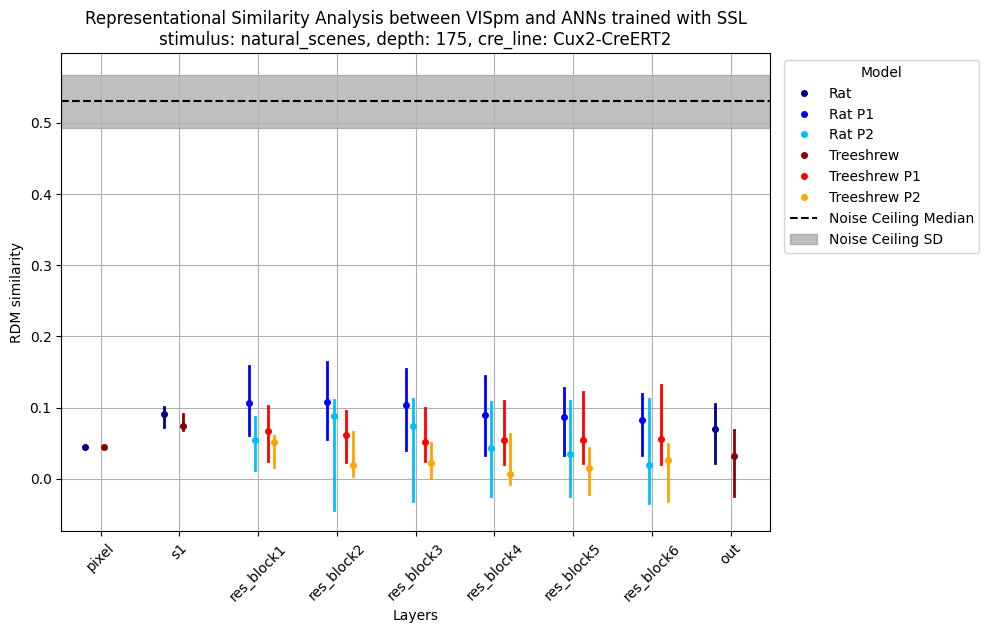

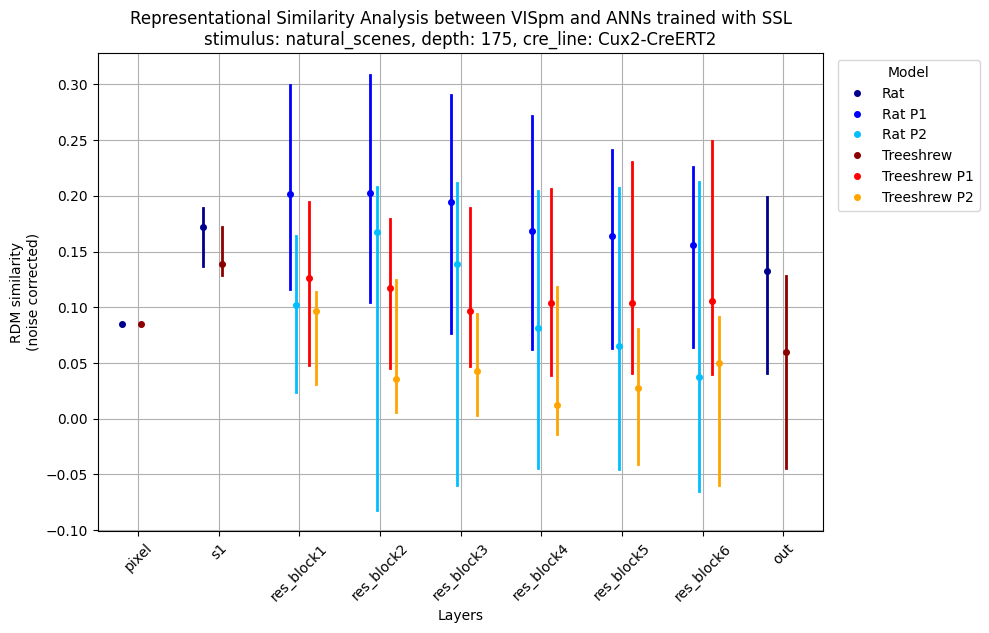

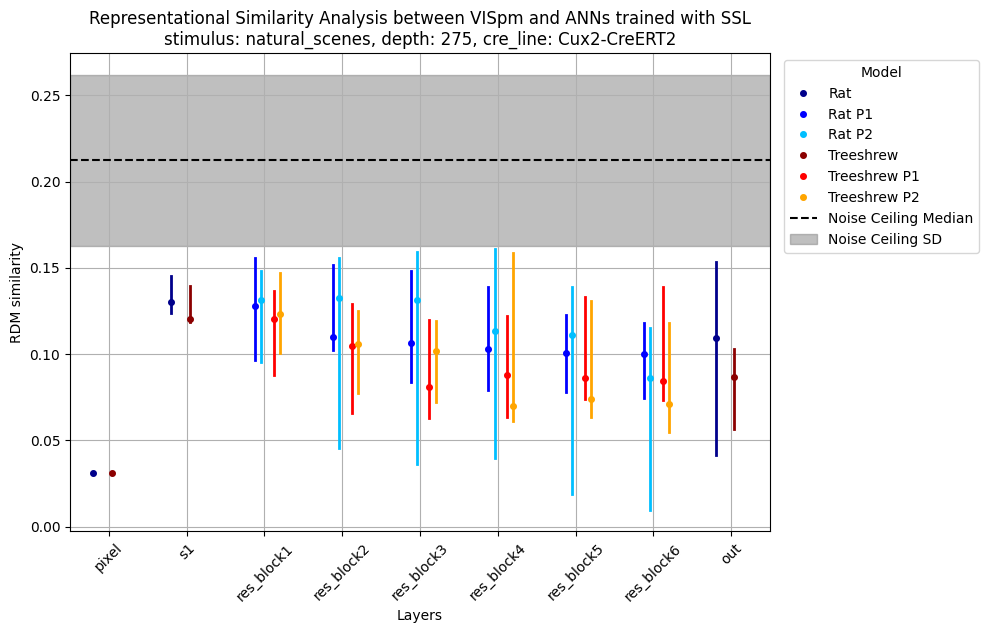

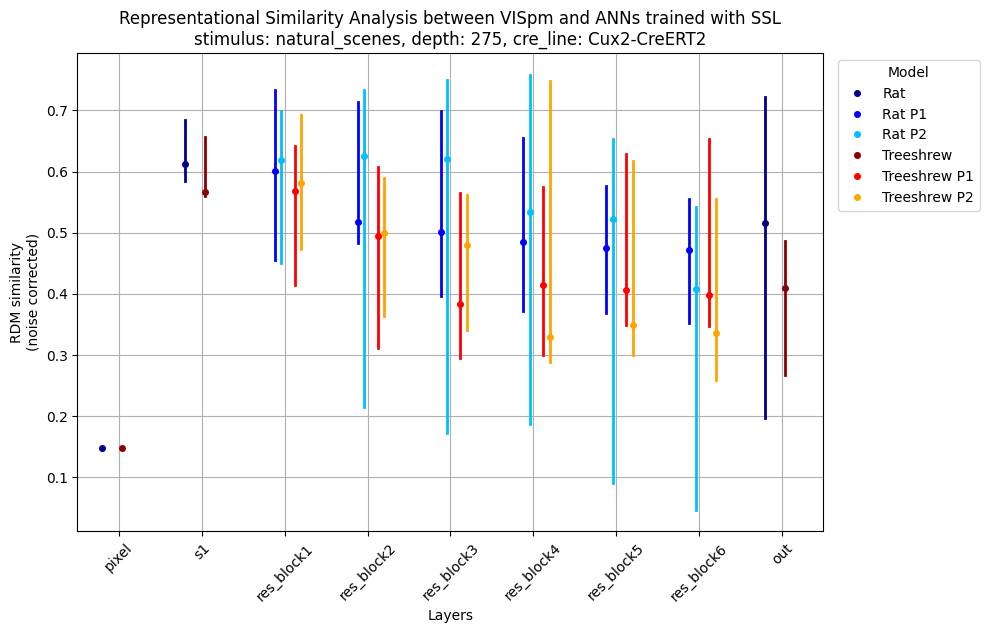

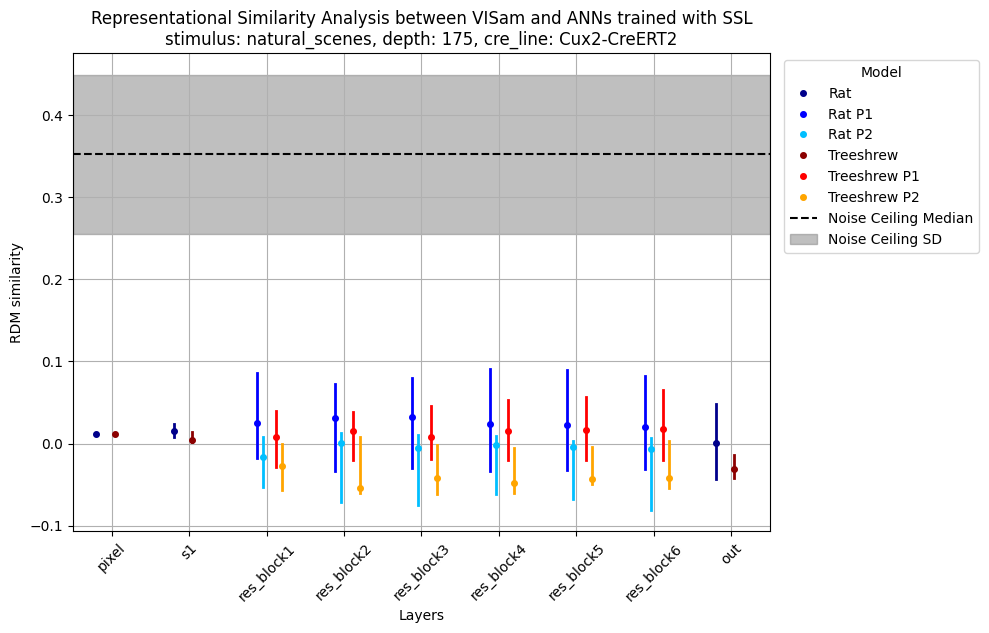

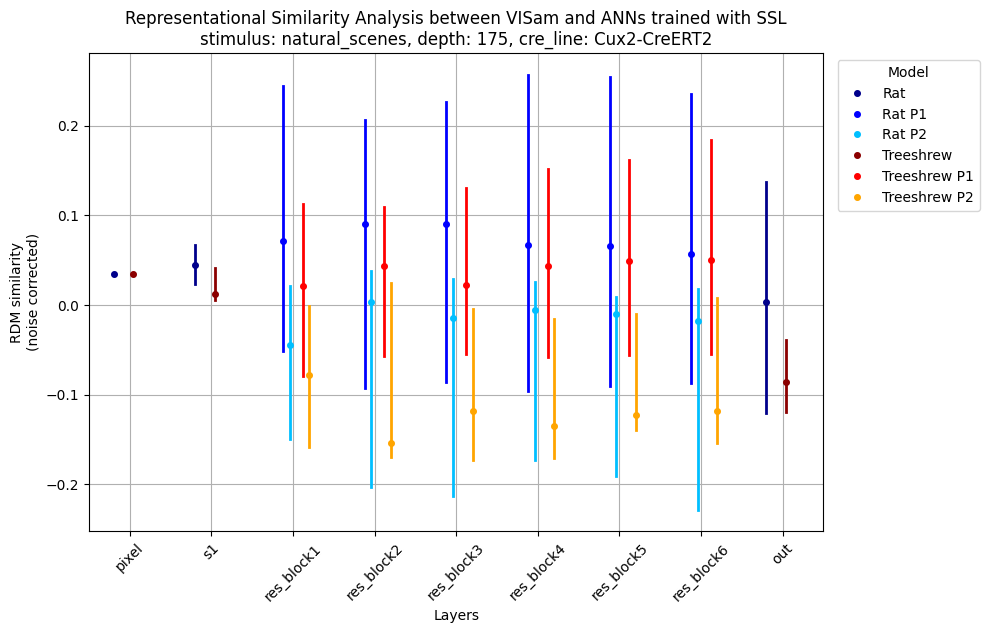

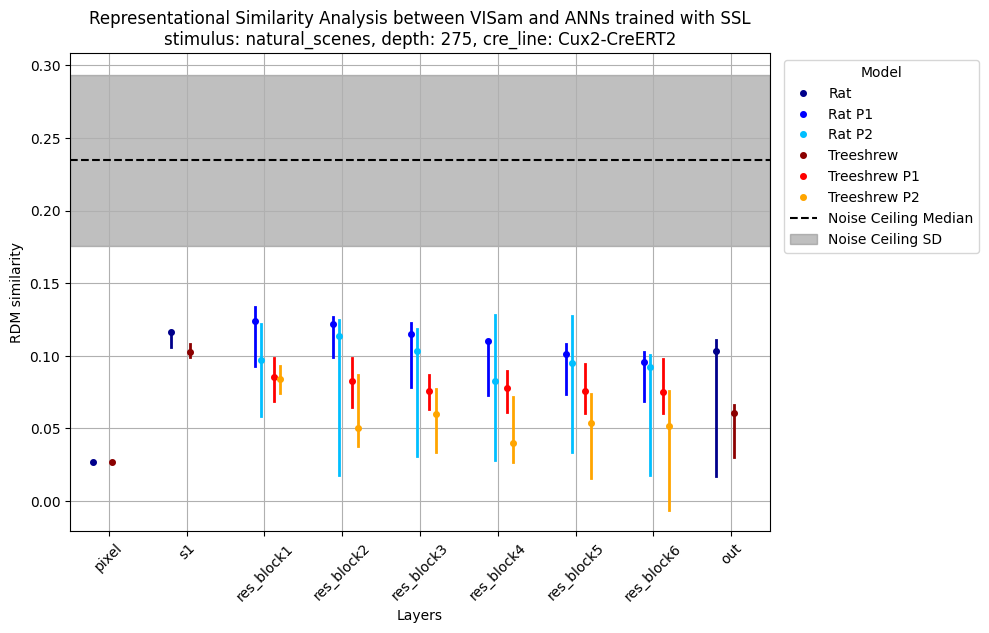

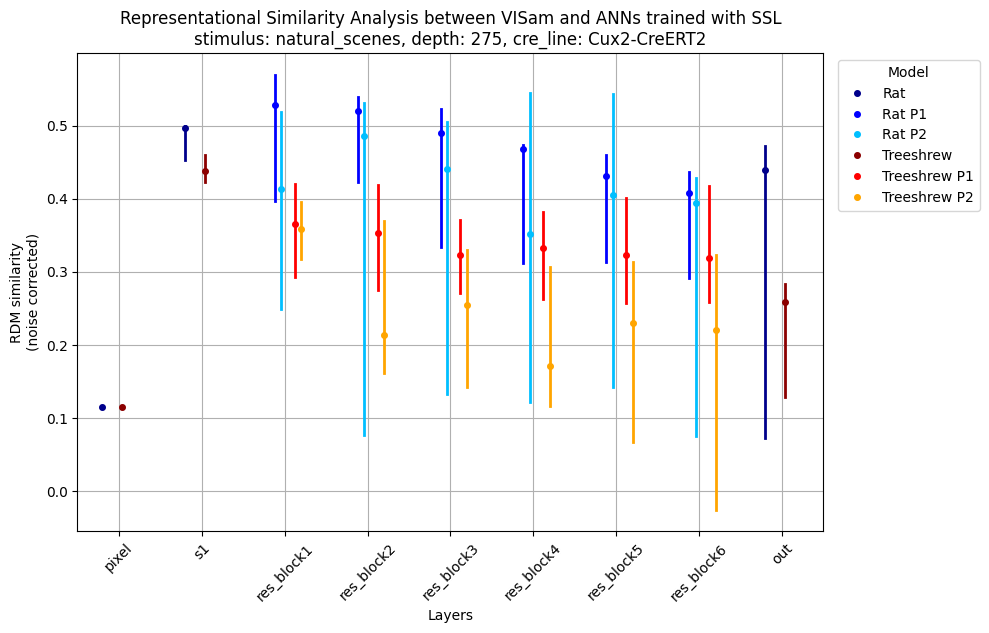

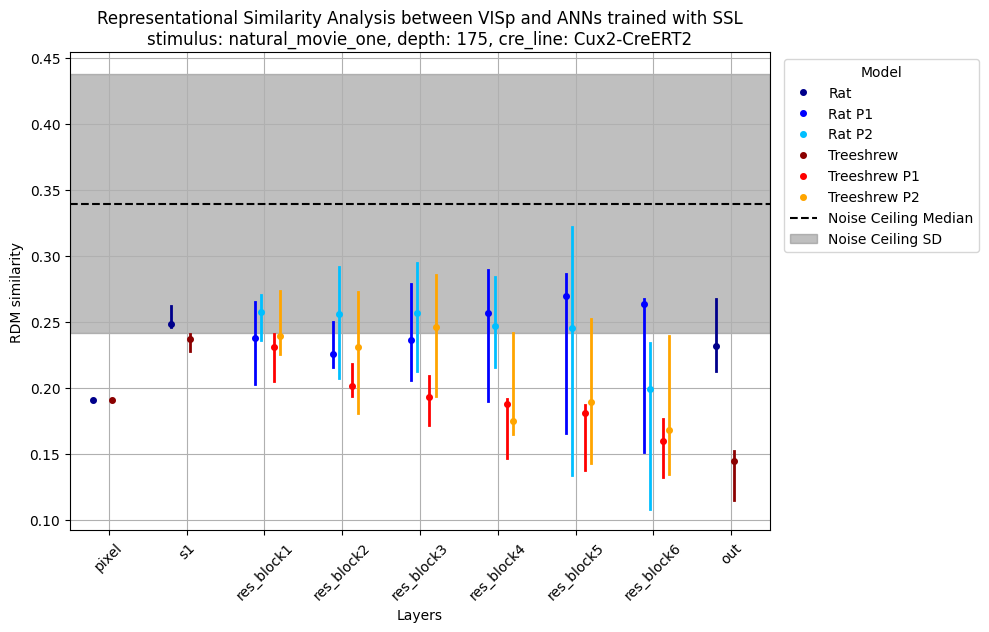

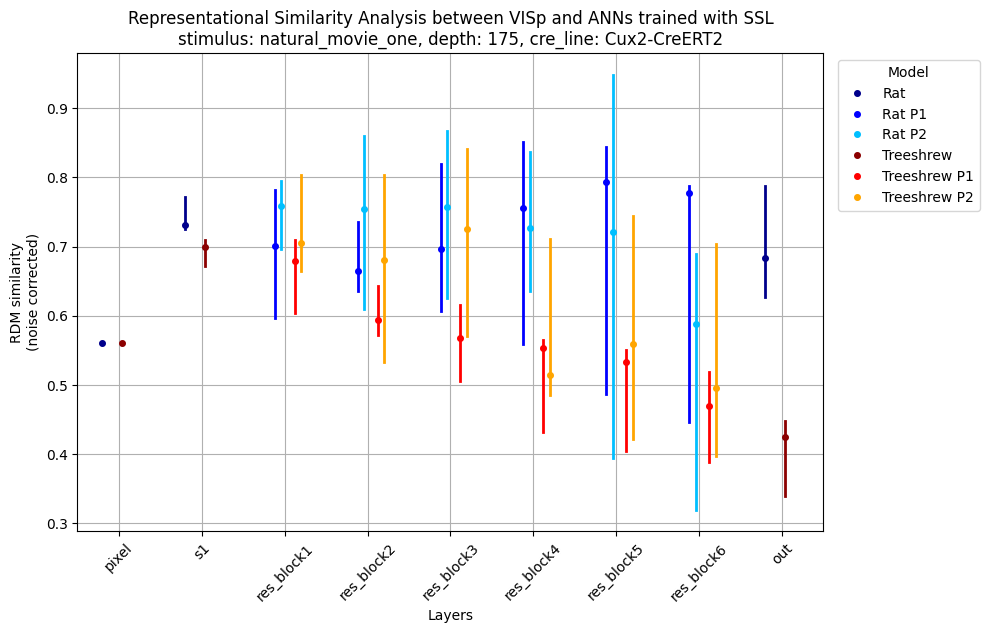

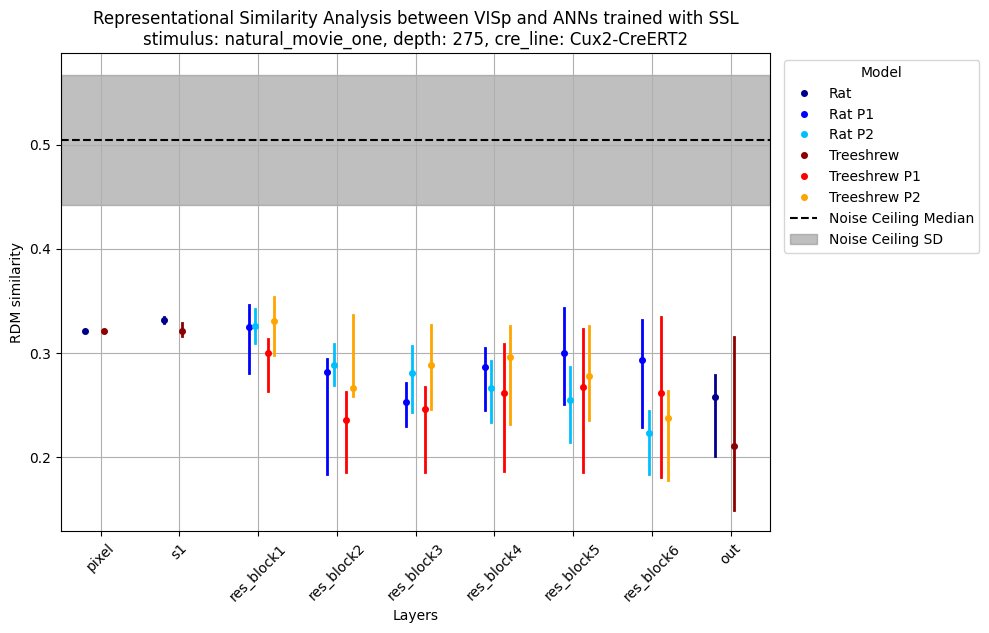

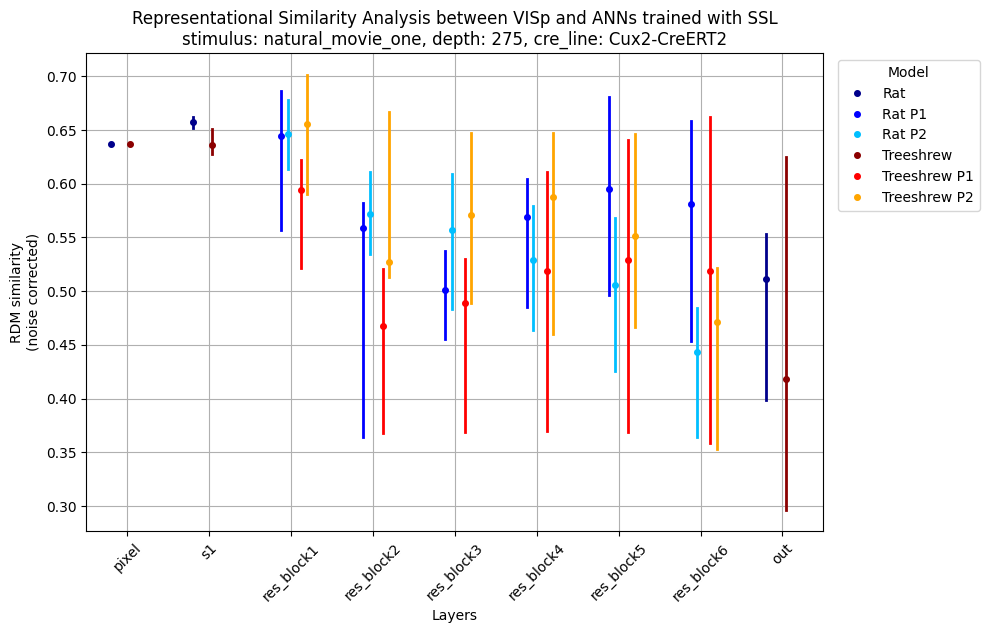

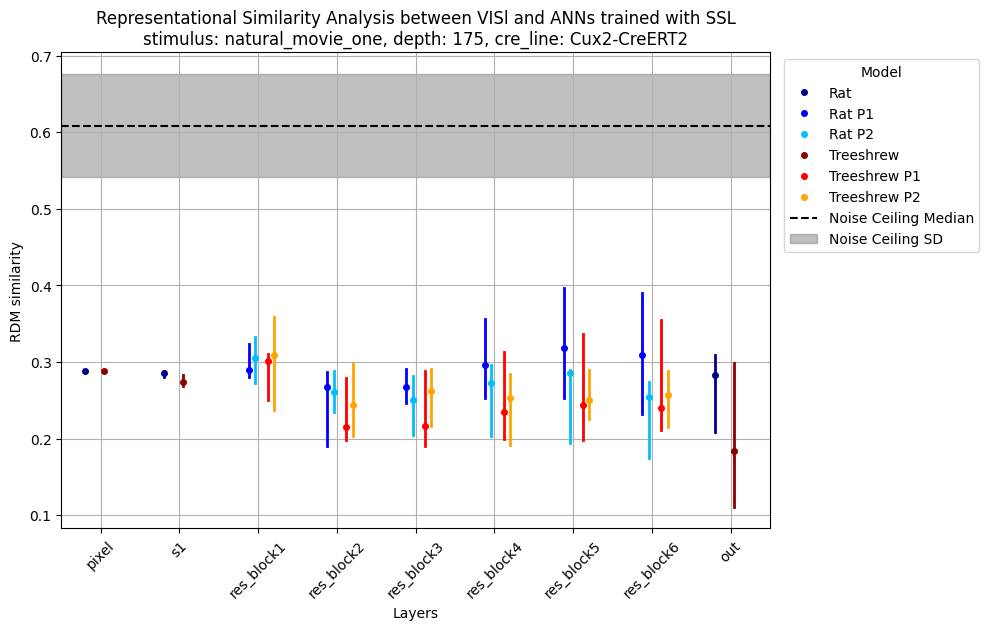

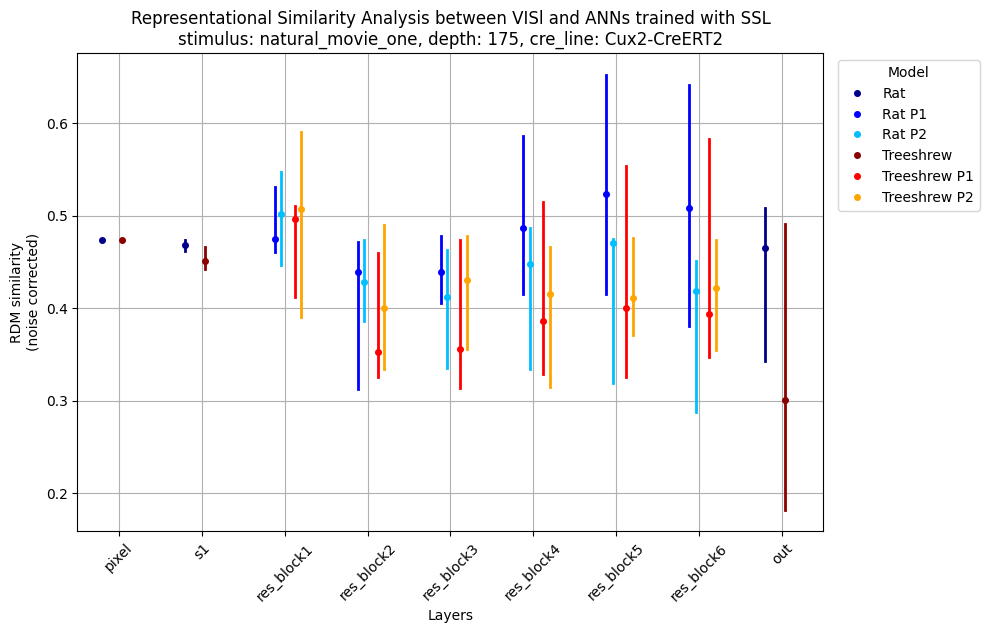

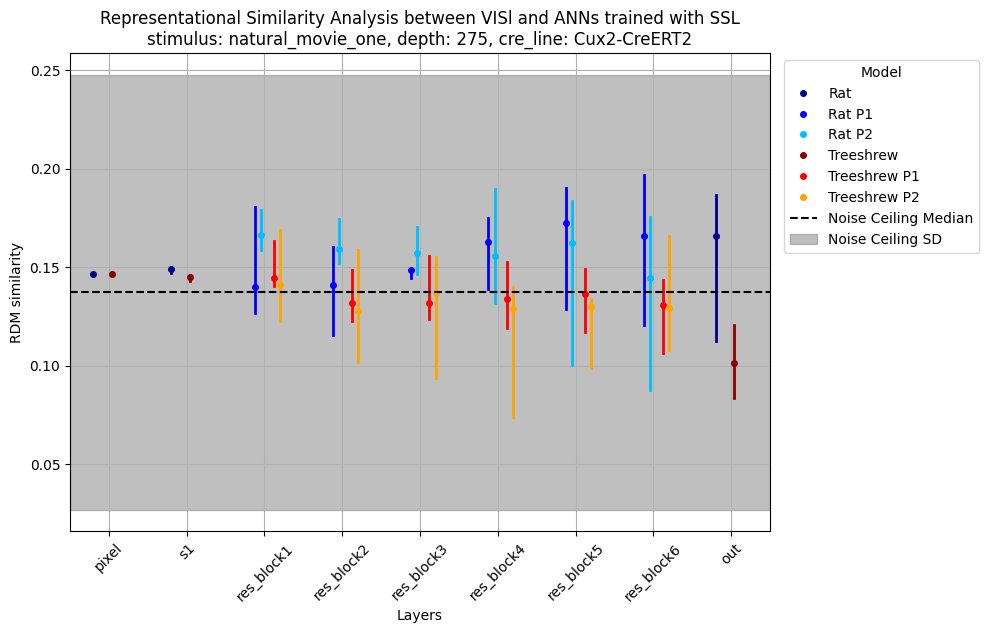

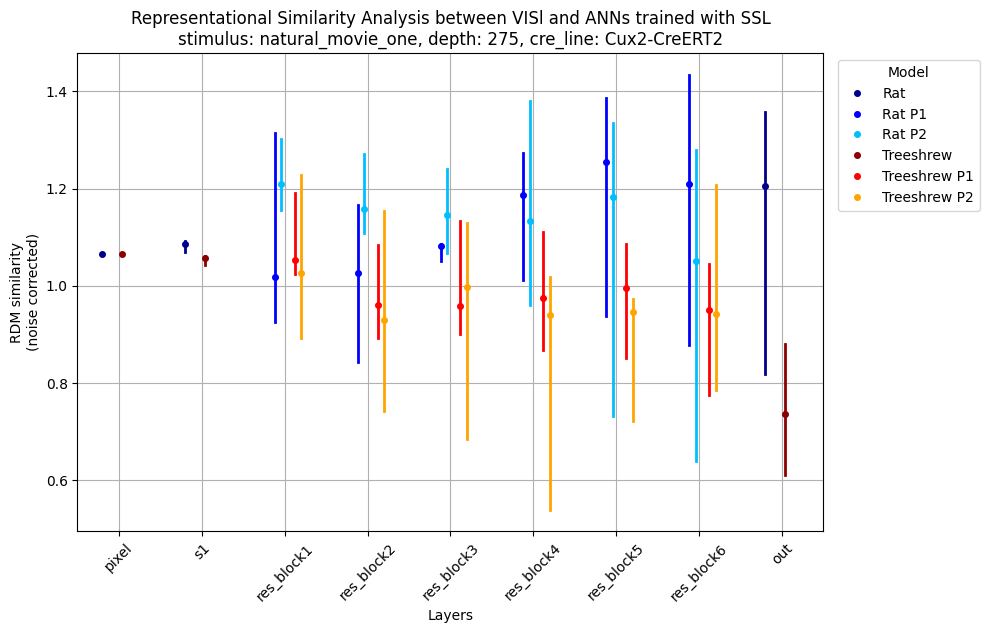

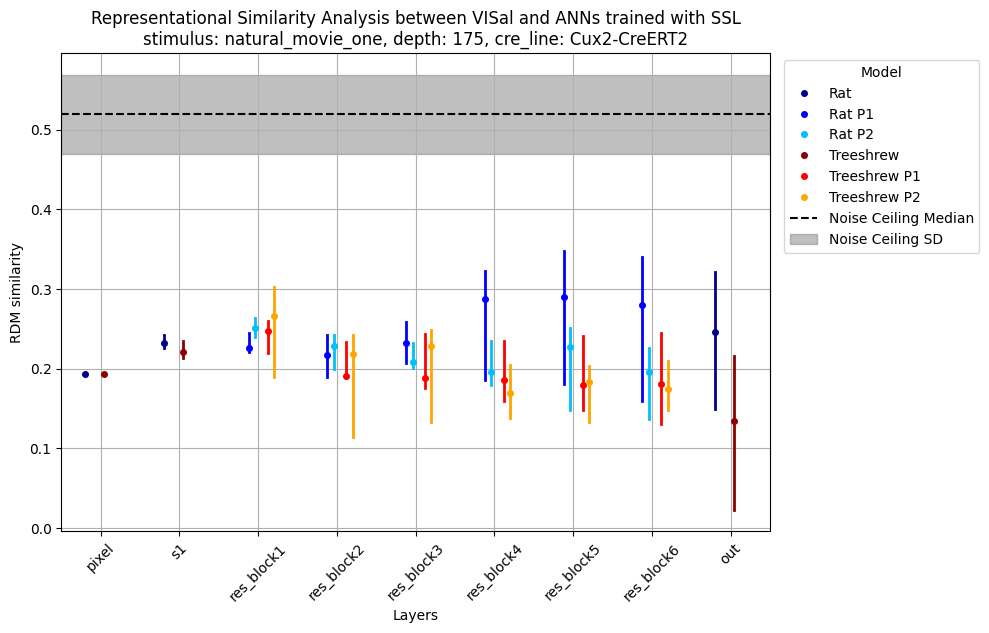

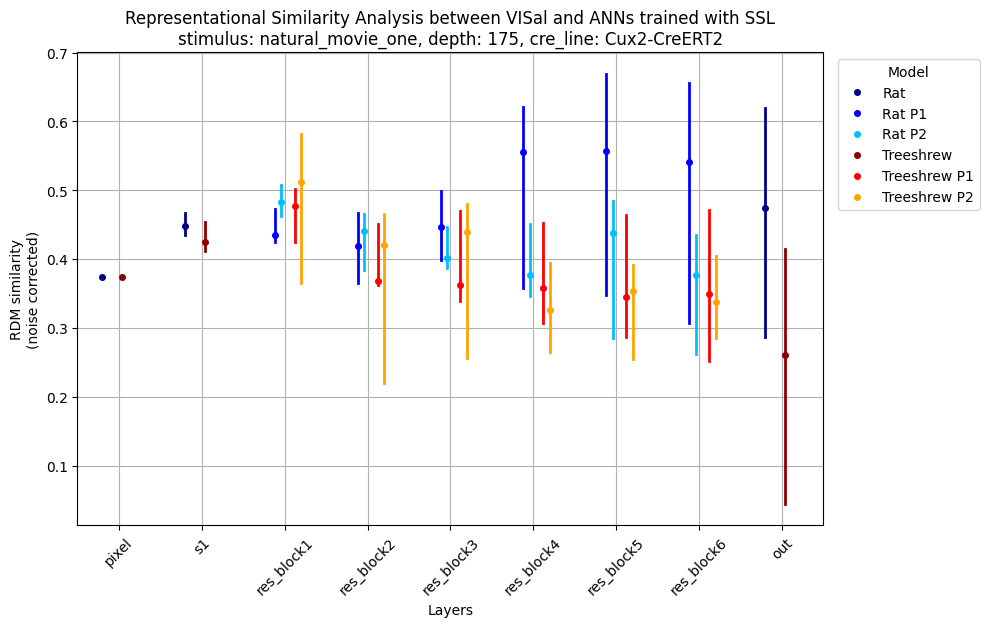

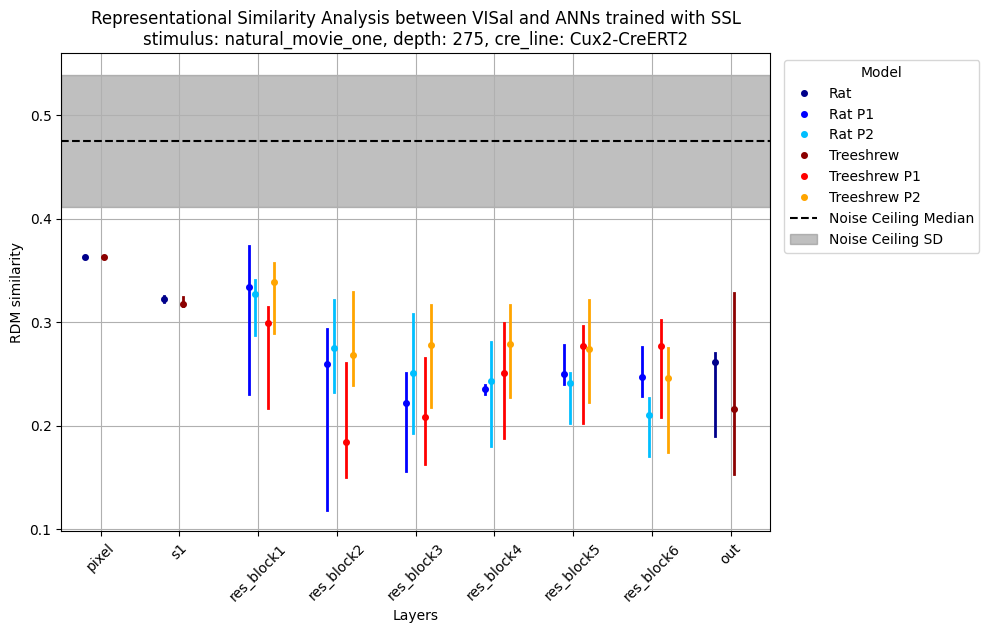

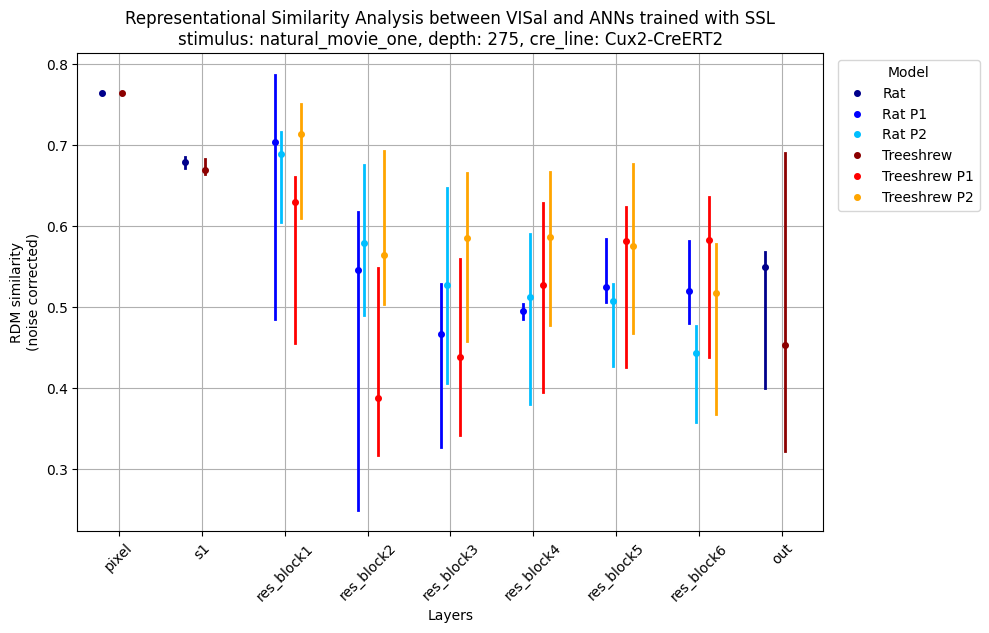

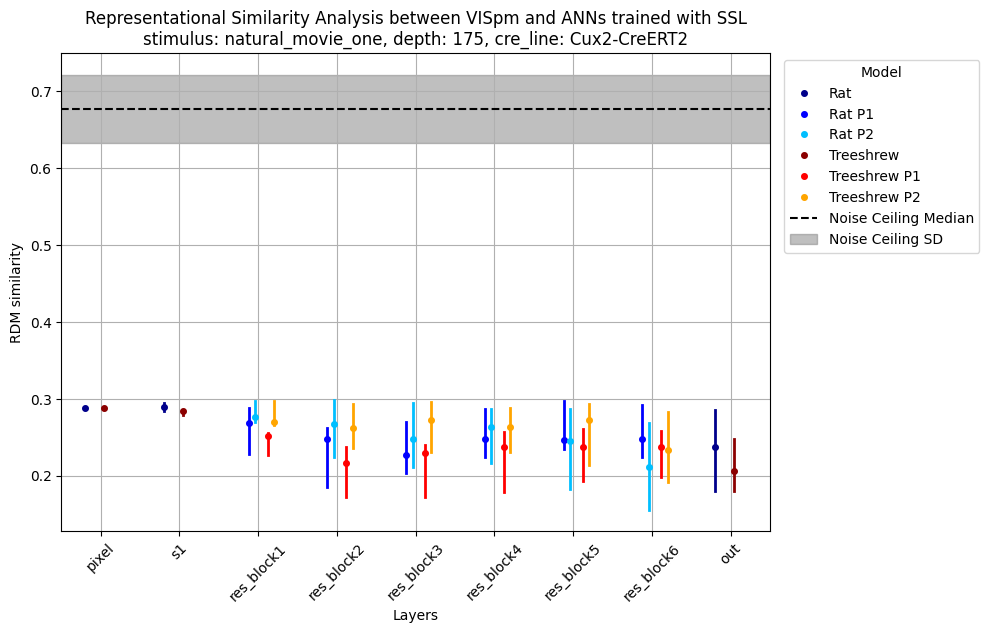

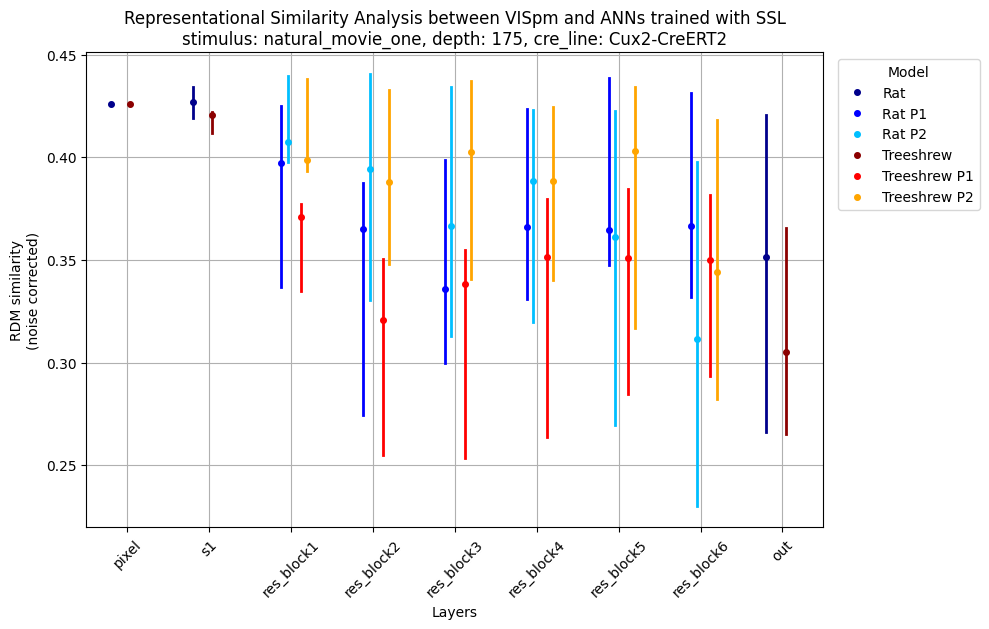

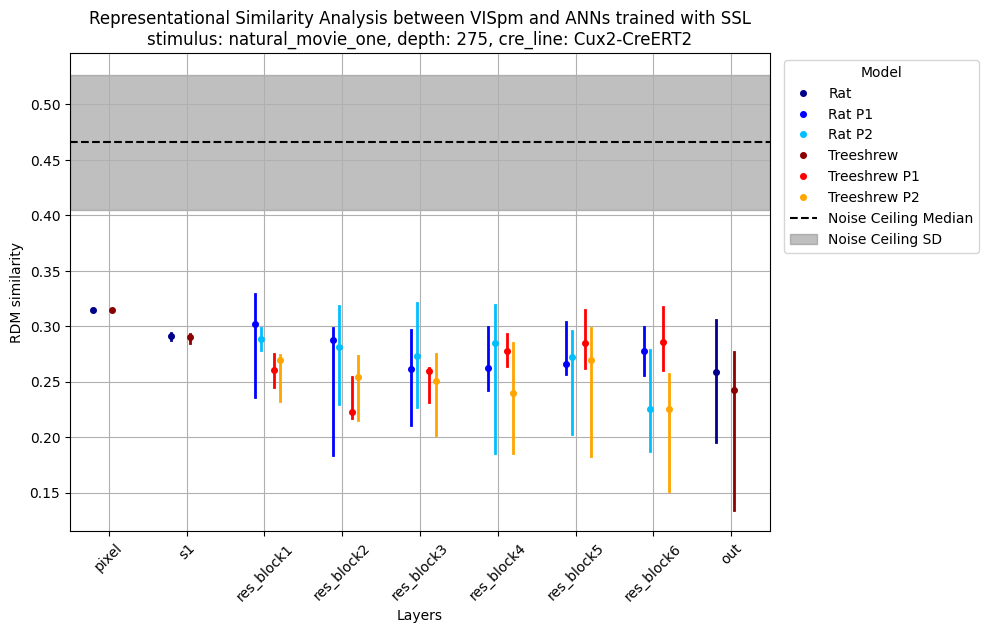

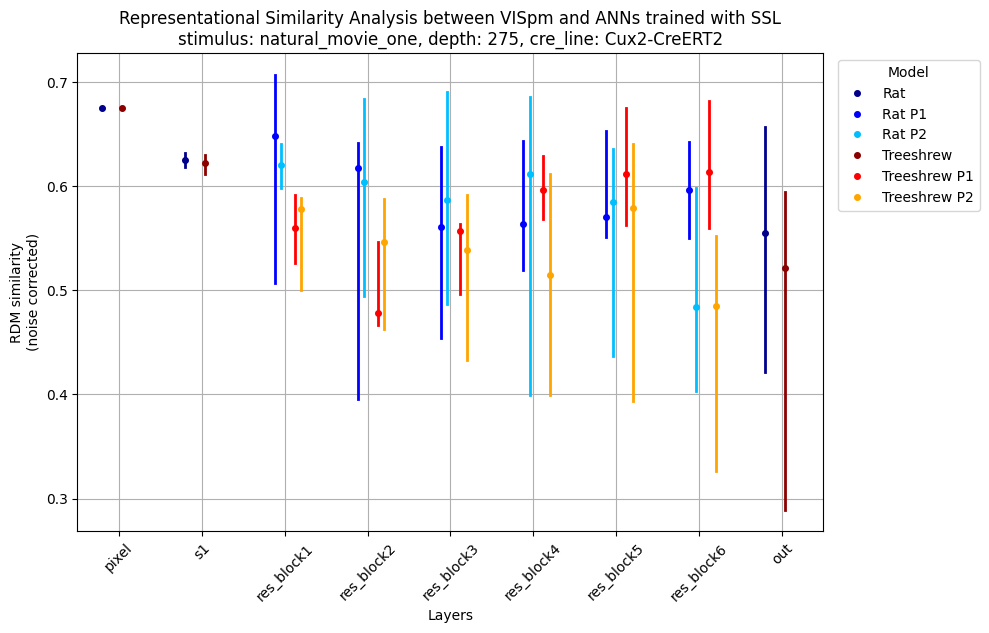

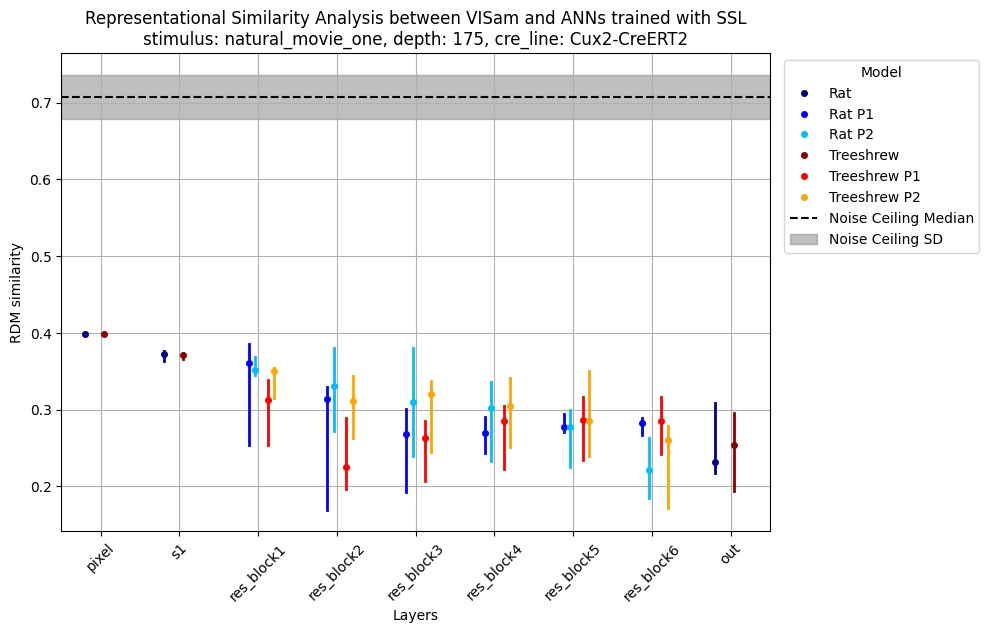

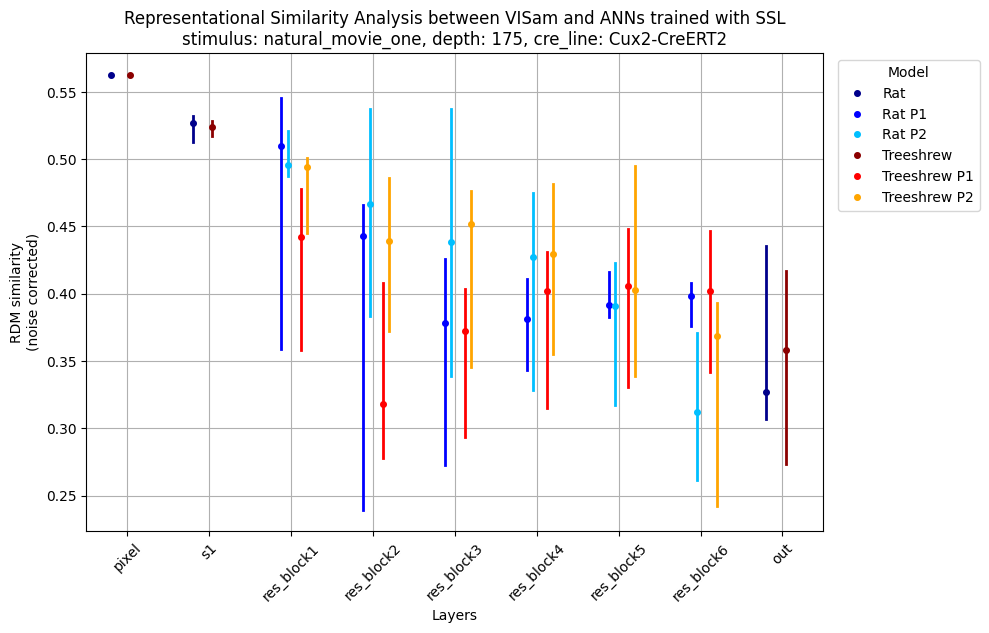

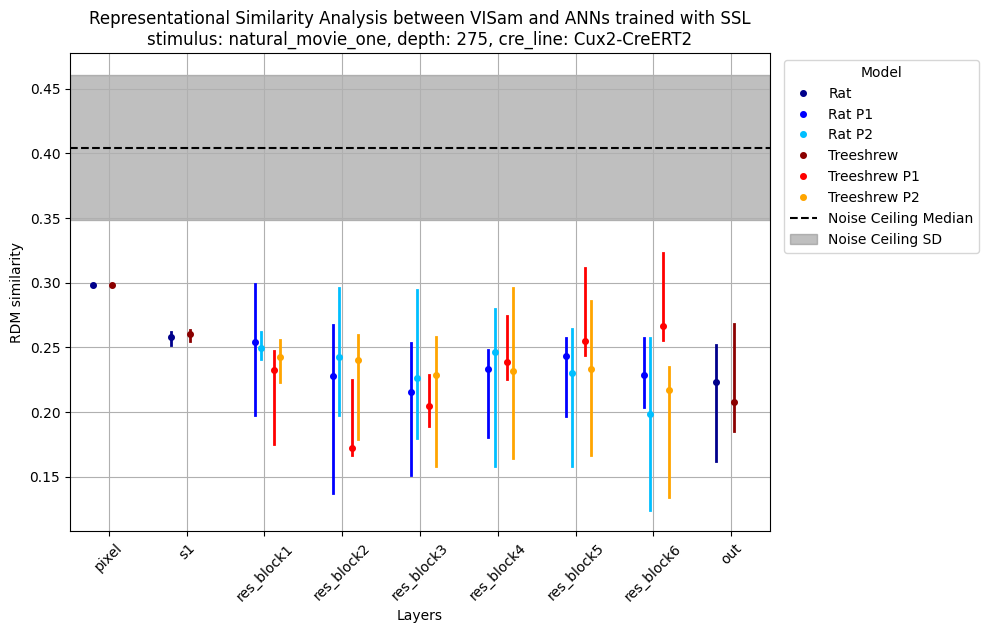

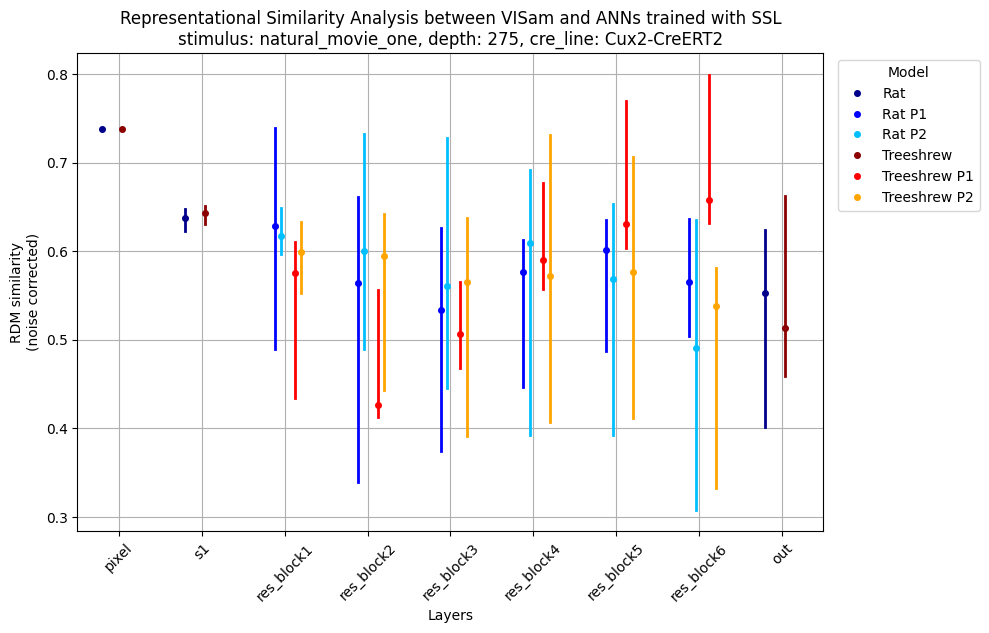

In [3]:
np.random.seed(42)

areas = [(area, depth, cre_line) for area in ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam'] for depth in [175, 275] for cre_line in ['Cux2-CreERT2']]     
num_iter = 100
models = {
    'Rat': sorted(glob.glob("../models/rat*.ckpt")),
    'Treeshrew': sorted(glob.glob("../models/ts*.ckpt"))
}

for stim_type in ['natural_scenes', 'natural_movie_one']:
    compare_rsa(models=models, areas=areas, stim_type=stim_type, num_iter=num_iter, seq_len=15, fig_path='../results')